# 为了得到一个领域内的模型

分为几个步骤。

1. 整理数据集；
2. 训练模型；
3. 使用训练好的模型来推理

## 整理数据集

我们参考[文本识别](https://paddlepaddle.github.io/PaddleOCR/latest/ppocr/model_train/recognition.html#13)这个站点来构建模型。

如果使用多语言模型训练数据集，需要过滤掉部分我们不需要的数据，例如非数字的数据。

我把数据存储到`meter_extra`目录下了。

### 开源合成工具 text_renderer

工具的网址是： https://github.com/Sanster/text_renderer。 我们目前没有使用这个工具。

- 我们没有采用lmdb格式的数据集


### 使用 ICDAR2015 数据集

- 没有使用。应该也需要过滤数字文件。

### 查看我们自己的数据集

1. 我们用的是真实图片
2. 用的是full-meter-reading area
3. train shape `32,300,3`; test and valid shape `32,192,3`

In [1]:
import os
import pathlib
from matplotlib import pyplot as plt

In [2]:

dataset = pathlib.Path('./train_data')
print(os.listdir(dataset / 'rec'))

def preview_dataset(filename):
  file = dataset / 'rec' / filename

  with open(file, 'r') as f:
    lines = f.readlines()[:3]
    print(lines)

  return lines

lines = preview_dataset('train_list.txt')
test_lines = preview_dataset('test.list')
val_lines = preview_dataset('valid.list')

['train_list.txt', 'valid', 'test.list', 'train', 'valid.list', 'test']
['rec/train/000000.png\t000828\n', 'rec/train/000001.png\t000917\n', 'rec/train/000002.png\t001857\n']
['rec/test/000000.png\t004829\n', 'rec/test/000001.png\t521090\n', 'rec/test/000002.png\t001110\n']
['rec/valid/000000.png\t001721\n', 'rec/valid/000001.png\t002685\n', 'rec/valid/000002.png\t000895\n']


[['rec/train/000000.png', '000828\n'], ['rec/train/000001.png', '000917\n'], ['rec/train/000002.png', '001857\n']]
3
[(32, 300, 3), (32, 300, 3), (32, 300, 3)]


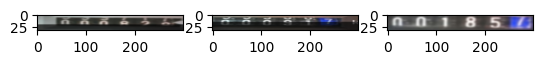

[['rec/test/000000.png', '004829\n'], ['rec/test/000001.png', '521090\n'], ['rec/test/000002.png', '001110\n']]
3
[(32, 192, 3), (32, 192, 3), (32, 192, 3)]


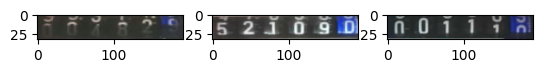

[['rec/valid/000000.png', '001721\n'], ['rec/valid/000001.png', '002685\n'], ['rec/valid/000002.png', '000895\n']]
3
[(32, 192, 3), (32, 192, 3), (32, 192, 3)]


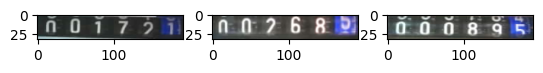

In [3]:
# 查看图片

def preview_img(lines):
  img_and_labels = [line.split('\t') for line in lines]
  print(img_and_labels)
  images = [plt.imread(dataset / il[0]) for il in img_and_labels]
  print(len(images))
  print([img.shape for img in images])

  plt.subplot(1, 3, 1)
  plt.imshow(images[0])
  plt.subplot(1, 3, 2)
  plt.imshow(images[1])
  plt.subplot(1, 3, 3)
  plt.imshow(images[2])
  plt.show()

preview_img(lines)
preview_img(test_lines)
preview_img(val_lines)

## 训练模型

通过上一步情况来看，我们数据集已经整理好了。下一步，我们使用这些数据进行训练。

这是原本`train_meter_v3.sh`的版本。

### config 文件

In [4]:
config_file = pathlib.Path('./atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml')
print(config_file.read_text())

Global:
  debug: false
  use_gpu: true
  epoch_num: 800
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/rec_ppocr_v3_distillation_meter
  save_epoch_step: 3
  eval_batch_step: [1, -1]
  cal_metric_during_train: true
  pretrained_model:
  checkpoints:
  save_inference_dir:
  use_visualdl: false
  infer_img: doc/imgs_words/ch/word_1.jpg
  character_dict_path: ppocr/utils/ppocr_keys_v1.txt
  # character_dict_path: ./atrain_script/meter_dict.txt # seems not work.
  max_text_length: &max_text_length 25
  infer_mode: false
  use_space_char: true
  distributed: true
  save_res_path: ./output/rec/predicts_ppocrv3_distillation_meter.txt
  d2s_train_image_shape: [3, 48, -1]
  use_wandb: True

wandb:  
  project: ProjectMeter  # (optional) this is the wandb project name

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Piecewise
    decay_epochs : [700]
    values : [0.0005, 0.00005]
    warmup_epoch: 5
  regularizer:
    name: L2
    factor: 3.0e-05



引入 wandb 来看训练过程中的数据

In [5]:
!pip install wandb
!git config --global --add safe.directory /opt/PaddleOCR

import wandb
wandb.login()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 536.3 kB/s eta 0:00:0000:0100:02

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: svtter (svtter-xiu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
!python -m paddle.distributed.launch --gpus '4,5,6,7' \
                       tools/train.py -c ./atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml \
                       -o Global.epoch_num=20 \
                       Global.eval_batch_step='[1000, 2000]' \
                       Train.dataset.data_dir=./train_data \
                       Train.dataset.label_file_list=['./train_data/rec/train_list.txt'] \
                       Train.loader.batch_size_per_card=64 \
                       Eval.dataset.data_dir=./train_data \
                       Eval.dataset.label_file_list=["./train_data/rec/valid.list"] \
                       Eval.loader.batch_size_per_card=64

LAUNCH INFO 2025-02-11 16:08:23,849 -----------  Configuration  ----------------------
LAUNCH INFO 2025-02-11 16:08:23,850 devices: 4,5,6,7
LAUNCH INFO 2025-02-11 16:08:23,850 elastic_level: -1
LAUNCH INFO 2025-02-11 16:08:23,850 elastic_timeout: 30
LAUNCH INFO 2025-02-11 16:08:23,850 gloo_port: 6767
LAUNCH INFO 2025-02-11 16:08:23,850 host: None
LAUNCH INFO 2025-02-11 16:08:23,850 ips: None
LAUNCH INFO 2025-02-11 16:08:23,850 job_id: default
LAUNCH INFO 2025-02-11 16:08:23,850 legacy: False
LAUNCH INFO 2025-02-11 16:08:23,850 log_dir: log
LAUNCH INFO 2025-02-11 16:08:23,850 log_level: INFO
LAUNCH INFO 2025-02-11 16:08:23,850 master: None
LAUNCH INFO 2025-02-11 16:08:23,850 max_restart: 3
LAUNCH INFO 2025-02-11 16:08:23,850 nnodes: 1
LAUNCH INFO 2025-02-11 16:08:23,850 nproc_per_node: None
LAUNCH INFO 2025-02-11 16:08:23,850 rank: -1
LAUNCH INFO 2025-02-11 16:08:23,850 run_mode: collective
LAUNCH INFO 2025-02-11 16:08:23,850 server_num: None
LAUNCH INFO 2025-02-11 16:08:23,850 servers:

## 推理模型

- 加载保存的最佳模型
- 查看 FPS

使用 paddlex + pipeline 加载最优的模型